Constructing Features from Scratch

#PL Dataset

In [1]:
#import libraries

import os
import sys
import numpy as np
# import torchtext
import pandas as pd
import re
import requests
import pickle
import yake
import nltk
from nltk.corpus import wordnet as wn
nltk.download('popular')

from lib import data_utils, preprocess

#get path
src_path = os.getcwd()

datapath = src_path + '/Data/'
PLcopath = datapath + 'AnnotatedPLData/PLCoref'
PLpath = datapath + 'AnnotatedPLData/PLTexts'
CENcopath = datapath + 'AnnotatedCENData/CENCoref'
CENpath = datapath + 'AnnotatedCENData/CENTexts'
ONpath = datapath + 'AnnotatedONData/ONCoref'

PLInter = src_path + '/output/IntermediateFilesPL/'
CENInter = src_path + '/output/IntermediateFilesCEN/'
ONInter = src_path + '/output/IntermediateFilesON/'

#import data

#create empty data frame
PL_data = pd.DataFrame(columns=['corpusID', 'character', 'animacy', 'coref_chain', 'chain_head', 'head_of_head', 'chain_len', 'CL'])

#append all PL texts and features into one dataframe
for n in range(1,47):
# for n in range(1,2):

    print(n)

    #get story path
    storycopath = PLcopath +'/story' + str(n) + '.txt'
    storypath = PLpath + '/story' + str(n) + '.txt'
    storyid = 'story'+ str(n)

    #read in story
    corpus = data_utils.read_story(storycopath)

    # read in from intermediate files
    # list of features
    # features = ["CN", "Dep", "NER", "SS", "Triple", "WN"]

    # for f in features:
    #     #empty list
    #     feat = []
    #     with open(PLInter + f + 'FeatureBoolean'+'/Story' + str(n) + '.txt', 'r') as doc:
    #         for line in doc:
    #             feat.append(eval(line.rstrip()))
    
    #     corpus[f] = feat

    #get ss feature
    sslist = preprocess.semantic_subj(storypath)
    #remove leading The/A's in the sematic list
    sslist = [re.sub('^(The |A )','',s, flags=re.IGNORECASE) for s in sslist]
    pattern = '|'.join(sslist)
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')
    
    #create binary flag variable for ss feat
    corpus['SS'] = corpus['head_of_head'].str.contains(pattern)
    corpus['SS'] = corpus['SS'].replace({True:1, False:0})

    #get ner feature
    nerlist = preprocess.ner_person(storypath)
    pattern = '|'.join(nerlist)
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')
    pattern = pattern.replace('[','')
    pattern = pattern.replace(']','')

    #create binary flag variable for ss feat
    corpus['NER'] = corpus['head_of_head'].str.contains(pattern)
    corpus['NER'] = corpus['NER'].replace({True:1, False:0})


    #create binary flag variable for wn feat
    #get wordnet synset of head of chain
    wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
   
    #fill blanks with unrelated word to person
    wn_input[0] = wn_input[0].fillna(wn.synset('strong.a.01'))
   
    # get common synonym with person
    per = wn.synset('person.n.01')
    test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
   
    # test if head of chain related to person
    corpus['WN']= test[0]==per
    corpus['WN'] = corpus['WN'].replace({True:1, False:0})

    #get dp feat
    dplist = preprocess.dep_link(storypath)
    dplist = list(set(dplist))
    pattern='|'.join(dplist)
    #remove punct
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace(')|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')

    #create binary flag variable for dp feat
    corpus['DP'] = corpus['head_of_head'].str.contains(pattern)
    corpus['DP'] = corpus['DP'].replace({True:1, False:0})

    #get triple feat
    tplist = preprocess.triple(storypath)
    tplist = list(set(tplist))
    #remove leading The/A's in the sematic list
    tplist = [re.sub('^(The |A )','',s, flags=re.IGNORECASE) for s in tplist]
    pattern='|'.join(tplist)
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace(')|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')

    #create binary flag variable for ss feat
    corpus['TP'] = corpus['head_of_head'].str.contains(pattern)
    corpus['TP'] = corpus['TP'].replace({True:1, False:0})

    # get conceptnet feat
    urlreq = 'https://api.conceptnet.io/c/en/'+corpus['head_of_head']

    #default no presence of person mentioned
    corpus['CN'] = 0

    for i in range(len(urlreq)):

        #make request to concept net api
        response = requests.get(urlreq[i])
        obj = response.json()
        #get list of edges
        cnlist = [edge['@id'] for edge in obj['edges']]

        #if person is in list then flag
        if any('person' in s for s in cnlist):
            val = 1
            corpus['CN'][i]=val
    
    #create feature for freq of head of chain term in text
    tf_dict = preprocess.term_freq(storypath)
    corpus['TF'] = corpus['head_of_head'].map(tf_dict)

    #create feature that contains keyword extraction score from yake
    f = open(storypath, 'r', encoding='ISO-8859-1')
    text = f.read()
    f.close()  

    kw_extractor = yake.KeywordExtractor(top = 100)
    keywords = dict(kw_extractor.extract_keywords(text))
    corpus['YK_SC'] = corpus['head_of_head'].map(keywords)
    corpus['YK_SC'] = corpus['YK_SC'].fillna(100)

    #append to dataframe
    PL_data = pd.concat([PL_data, corpus], ignore_index=True)

PL_data.to_csv("Data/PL.csv")
PL_data

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:86: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

6


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

7


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

8


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

9


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

10


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

11


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

12


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:86: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

13


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:66: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, u

14


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

15


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

16


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

17


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

18


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

19


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

20


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

21


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

22


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

23


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

24


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

25


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

26


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

27


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

28


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

29


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

30


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

31


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

32


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

33


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

34


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

35


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

36


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

38


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

39


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

40


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

41


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

43


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

44


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

45


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

46


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_4200/2542963973.py:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

,corpusID,character,animacy,coref_chain,chain_head,head_of_head,chain_len,CL,SS,NER,WN,DP,TP,CN
0,story1,1,1,"[ dragon , he , he , the dragon , He , hi...",dragon,dragon,43,2.499540,1.0,0.0,0.0,1.0,1.0,1.0
1,story1,1,1,"[ princess , the tsar 's daughter , her , h...",princess,princess,23,0.990763,1.0,0.0,1.0,1.0,1.0,1.0
2,story1,1,1,"[ tsar , tsar , father , tsar , her father...",tsar,tsar,9,-0.065380,1.0,0.0,1.0,1.0,1.0,1.0
3,story1,0,1,"[ princess' dog , a little dog that had follo...",princess' dog,dog,4,-0.442574,1.0,0.0,0.0,1.0,1.0,1.0
4,story1,1,1,"[ tsarina , mother , tsarina , tsarina ]",tsarina,tsarina,4,-0.442574,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,story46,0,1,"[ the entire enemy army , the enemy army , h...",the entire enemy army,army,7,-0.308434,0.0,0.0,0.0,0.0,0.0,0.0
1908,story46,0,1,"[ this , the best solution ]",this,this,2,-0.604613,1.0,0.0,0.0,1.0,0.0,0.0
1909,story46,0,1,"[ a horse , a horse ]",a horse,horse,2,-0.604613,0.0,0.0,0.0,0.0,0.0,0.0
1910,story46,0,1,"[ an even better horse , his horse , his hor...",an even better horse,horse,4,-0.486142,0.0,0.0,0.0,0.0,0.0,0.0


#CEN Datasest

In [1]:
#import libraries

import os
import sys
import numpy as np
# import torchtext
import pandas as pd
import re
import requests
import nltk
import yake
from nltk.corpus import wordnet as wn
nltk.download('popular')

from lib import data_utils, preprocess

#get path
src_path = os.getcwd()

datapath = src_path + '/Data/'
PLcopath = datapath + 'AnnotatedPLData/PLCoref'
PLpath = datapath + 'AnnotatedPLData/PLTexts'
CENcopath = datapath + 'AnnotatedCENData/CENCoref'
CENpath = datapath + 'AnnotatedCENData/CENTexts'
ONpath = datapath + 'AnnotatedONData/ONCoref'

PLInter = src_path + '/output/IntermediateFilesPL/'
CENInter = src_path + '/output/IntermediateFilesCEN/'
ONInter = src_path + '/output/IntermediateFilesON/'

#import data

#create empty data frame
CEN_data = pd.DataFrame(columns=['corpusID', 'character', 'animacy', 'coref_chain', 'chain_head', 'head_of_head', 'chain_len', 'CL'])

#append all PL texts and features into one dataframe
for n in range(1,31):
# for n in range(1,2):

    print(n)

    #get story path
    storycopath = CENcopath +'/Novel' + str(n) + '.txt'
    storypath = CENpath + '/Novel' + str(n) + '.txt'
    storyid = 'Novel'+ str(n)

    #read in story
    corpus = data_utils.read_story(storycopath)

    # read in from intermediate files
    # list of features
    # features = ["CN", "Dep", "NER", "SS", "Triple", "WN"]

    # for f in features:
    #     #empty list
    #     feat = []
    #     with open(PLInter + f + 'FeatureBoolean'+'/Story' + str(n) + '.txt', 'r') as doc:
    #         for line in doc:
    #             feat.append(eval(line.rstrip()))
    
    #     corpus[f] = feat

    #get ss feature
    sslist = preprocess.semantic_subj(storypath)
    #remove leading The/A's in the sematic list
    sslist = [re.sub('^(The |A )','',s, flags=re.IGNORECASE) for s in sslist]
    pattern = '|'.join(sslist)
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')
    
    #create binary flag variable for ss feat
    corpus['SS'] = corpus['head_of_head'].str.contains(pattern)
    corpus['SS'] = corpus['SS'].replace({True:1, False:0})

    #get ner feature
    nerlist = preprocess.ner_person(storypath)
    pattern = '|'.join(nerlist)
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')
    pattern = pattern.replace('[','')
    pattern = pattern.replace(']','')

    #create binary flag variable for ss feat
    corpus['NER'] = corpus['head_of_head'].str.contains(pattern)
    corpus['NER'] = corpus['NER'].replace({True:1, False:0})


    #create binary flag variable for wn feat
    #get wordnet synset of head of chain
    wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
   
    #fill blanks with unrelated word to person
    wn_input[0] = wn_input[0].fillna(wn.synset('strong.a.01'))
   
    # get common synonym with person
    per = wn.synset('person.n.01')
    test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
   
    # test if head of chain related to person
    corpus['WN']= test[0]==per
    corpus['WN'] = corpus['WN'].replace({True:1, False:0})

    #get dp feat
    dplist = preprocess.dep_link(storypath)
    dplist = list(set(dplist))
    pattern='|'.join(dplist)
    #remove punct
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace(')|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')

    #create binary flag variable for dp feat
    corpus['DP'] = corpus['head_of_head'].str.contains(pattern)
    corpus['DP'] = corpus['DP'].replace({True:1, False:0})

    #get triple feat
    tplist = preprocess.triple(storypath)
    tplist = list(set(tplist))
    #remove leading The/A's in the sematic list
    tplist = [re.sub('^(The |A )','',s, flags=re.IGNORECASE) for s in tplist]
    pattern='|'.join(tplist)
    pattern = pattern.replace('?|','')
    pattern = pattern.replace('!|','')
    pattern = pattern.replace('.|','')
    pattern = pattern.replace('(|','')
    pattern = pattern.replace(')|','')
    pattern = pattern.replace('(','')
    pattern = pattern.replace(')','')

    #create binary flag variable for ss feat
    corpus['TP'] = corpus['head_of_head'].str.contains(pattern)
    corpus['TP'] = corpus['TP'].replace({True:1, False:0})

    # get conceptnet feat
    urlreq = 'https://api.conceptnet.io/c/en/'+corpus['head_of_head']

    #default no presence of person mentioned
    corpus['CN'] = 0

    for i in range(len(urlreq)):

        #make request to concept net api
        response = requests.get(urlreq[i])
        obj = response.json()
        #get list of edges
        cnlist = [edge['@id'] for edge in obj['edges']]

        #if person is in list then flag
        if any('person' in s for s in cnlist):
            val = 1
            corpus['CN'][i]=val
    
    #create feature for term freq
    tf_dict = preprocess.term_freq(storypath)
    corpus['TF'] = corpus['head_of_head'].map(tf_dict)

    #create feature that contains keyword extraction score from yake
    f = open(storypath, 'r', encoding='ISO-8859-1')
    text = f.read()
    f.close()  

    kw_extractor = yake.KeywordExtractor(top=100)
    keywords = dict(kw_extractor.extract_keywords(text))
    corpus['YK_SC'] = corpus['head_of_head'].map(keywords)
    # corpus['YK_SC'] = corpus['chain_head'].map(keywords)
    corpus['YK_SC'] = corpus['YK_SC'].fillna(100)

    #append to dataframe
    CEN_data = pd.concat([CEN_data, corpus], ignore_index=True)

CEN_data.to_csv('Data/CEN.csv')
CEN_data

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/eileen/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

1


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ip

2


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

3


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

4


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

5


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

6


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

7


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

8


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

9


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

10


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

11


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

12


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

13


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

14


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

15


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

16


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

17


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

18


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

19


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

20


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

21


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

22


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

23


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

24


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

25


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

26


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

27


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

28


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

29


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

30


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/tmp/ipykernel_461268/2464705671.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wn_input = corpus['head_of_head'].apply(lambda word: pd.Series(wn.synsets(word)))
/tmp/ipykernel_461268/2464705671.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = wn_input[0].apply(lambda syn: pd.Series(syn.lowest_common_hypernyms(per)))
/tmp/ipykernel_461268/2464705671.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,corpusID,character,animacy,coref_chain,chain_head,head_of_head,chain_len,CL,SS,NER,WN,DP,TP,CN,TF,YK_SC
0,Novel1,1,1,"[ Barold , He , him , Barold 's , Barold ,...",Barold,Barold,28,2.837451,0.0,1.0,0.0,1.0,1.0,0.0,0.003622,0.035029
1,Novel1,1,1,"[ Lucia , Lucia , Lucia , Lucia , who had b...",Lucia,Lucia,17,1.487132,1.0,1.0,0.0,1.0,1.0,0.0,0.004074,0.034517
2,Novel1,1,1,"[ Octavia , Octavia , I , Octavia , I , M...",Octavia,Octavia,24,2.346426,1.0,1.0,0.0,1.0,1.0,0.0,0.006338,0.015361
3,Novel1,1,1,"[ Lady Theobald 's , furious Lady Theobald , ...",Lady Theobald 's,'s,12,0.873350,0.0,0.0,0.0,0.0,0.0,0.0,0.008601,100.000000
4,Novel1,1,1,"[ Octavia and Lord Lansdowne , Lord Lansdowne...",Octavia and Lord Lansdowne,Lansdowne,16,1.364375,0.0,1.0,0.0,1.0,0.0,0.0,0.002716,0.039249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,Novel30,0,0,[ them ],them,them,1,-0.218213,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,100.000000
5804,Novel30,0,0,[ Giovanni 's shoulders ],Giovanni 's shoulders,shoulders,1,-0.218213,0.0,0.0,0.0,0.0,0.0,0.0,0.000409,100.000000
5805,Novel30,0,0,[ his angry eyes ],his angry eyes,eyes,1,-0.218213,1.0,0.0,0.0,1.0,0.0,0.0,0.002456,0.082623
5806,Novel30,0,1,"[ My beloved , I , I , I , Especially I , ...",My beloved,beloved,10,0.812119,0.0,0.0,1.0,0.0,0.0,1.0,0.000409,100.000000


Importing Features from Intermediate File

#PL Dataset

In [11]:
#import libraries

import os
import sys
import numpy as np
# import torchtext
import pandas as pd
import re

from lib import data_utils, preprocess

#get path
src_path = os.getcwd()

datapath = src_path + '/Data/'
PLcopath = datapath + 'AnnotatedPLData/PLCoref'
PLpath = datapath + 'AnnotatedPLData/PLTexts'
CENcopath = datapath + 'AnnotatedCENData/CENCoref'
CENpath = datapath + 'AnnotatedCENData/CENCoref'
ONpath = datapath + 'AnnotatedONData/ONCoref'

PLInter = src_path + '/output/IntermediateFilesPL/'
CENInter = src_path + '/output/IntermediateFilesCEN/'
ONInter = src_path + '/output/IntermediateFilesON/'

#import data

#create empty data frame
PL_Int_data = pd.DataFrame(columns=['corpusID', 'character', 'animacy', 'coref_chain', 'chain_head', 'head_of_head', 'chain_len', 'CL'])

#append all PL texts and features into one dataframe
for n in range(1,47):
# for n in range(1,2):

    print(n)

    #get story path
    storycopath = PLcopath +'/story' + str(n) + '.txt'
    storypath = PLpath + '/story' + str(n) + '.txt'
    storyid = 'story'+ str(n)

    #read in story
    corpus = data_utils.read_story(storycopath)

    #read in from intermediate files
    #list of features
    features = ["CN", "Dep", "NER", "SS", "Triple", "WN"]

    for f in features:
        #empty list
        feat = []
        with open(PLInter + f + 'FeatureBoolean'+'/Story' + str(n) + '.txt', 'r') as doc:
            for line in doc:
                feat.append(eval(line.rstrip()))
    
        corpus[f] = feat
    
    #creat feature for term freq
    tf_dict = preprocess.term_freq(storypath)
    corpus['TF'] = corpus['head_of_head'].map(tf_dict)

    #create feature that contains keyword extraction score from yake
    f = open(storypath, 'r', encoding='ISO-8859-1')
    text = f.read()
    f.close()  

    kw_extractor = yake.KeywordExtractor(top=100)
    keywords = dict(kw_extractor.extract_keywords(text))
    corpus['YK_SC'] = corpus['head_of_head'].map(keywords)
    corpus['YK_SC'] = corpus['YK_SC'].fillna(100)

    #append to dataframe
    PL_Int_data = pd.concat([PL_Int_data, corpus], ignore_index=True)
PL_Int_data

'Everything|The|you|them|one|lady|daughter|debtors|devil|Satan|but|there|Hey|women|and|There|where|we|Pack|princess|king|,|job|It|We|How|Out|They||tavern|how|brother|That|what|thirteen|Wander|they|"|Order|hammers|spirits|wandered|No|served|soldier|head|everything|many|foreign|road|has|he|it|devils|You|kind|heart|But|that|He|spirit|I|his|Each|she|Lord|who|What|Do|\'s'

#CEN Data

In [ ]:
#import libraries

import os
import sys
import numpy as np
# import torchtext
import pandas as pd
import re
import yake

from lib import data_utils, preprocess

#get path
src_path = os.getcwd()

datapath = src_path + '/Data/'
PLcopath = datapath + 'AnnotatedPLData/PLCoref'
PLpath = datapath + 'AnnotatedPLData/PLTexts'
CENcopath = datapath + 'AnnotatedCENData/CENCoref'
CENpath = datapath + 'AnnotatedCENData/CENCoref'
ONpath = datapath + 'AnnotatedONData/ONCoref'

PLInter = src_path + '/output/IntermediateFilesPL/'
CENInter = src_path + '/output/IntermediateFilesCEN/'
ONInter = src_path + '/output/IntermediateFilesON/'

#import data

#create empty data frame
CEN_Int_data = pd.DataFrame(columns=['corpusID', 'character', 'animacy', 'coref_chain', 'chain_head', 'head_of_head', 'chain_len', 'CL'])

#append all PL texts and features into one dataframe
for n in range(1,31):
# for n in range(1,2):

    print(n)

    #get story path
    storycopath = CENcopath +'/Novel' + str(n) + '.txt'
    storypath = CENpath + '/Novel' + str(n) + '.txt'
    storyid = 'Novel'+ str(n)

    #read in story
    corpus = data_utils.read_story(storycopath)

    #read in from intermediate files
    #list of features
    features = ["CN", "Dep", "NER", "SS", "Triple", "WN"]

    for f in features:
        #empty list
        feat = []
        with open(CENInter + f + 'FeatureBoolean'+'/Novel' + str(n) + '.txt', 'r') as doc:
            for line in doc:
                feat.append(eval(line.rstrip()))
    
        corpus[f] = feat
    
    #create feature for term freq
    tf_dict = preprocess.term_freq(storypath)
    corpus['TF'] = corpus['head_of_head'].map(tf_dict)

    #create feature that contains keyword extraction score from yake
    f = open(storypath, 'r', encoding='ISO-8859-1')
    text = f.read()
    f.close()  

    kw_extractor = yake.KeywordExtractor(top = 100)
    keywords = dict(kw_extractor.extract_keywords(text))
    # corpus['YK_SC'] = corpus['head_of_head'].map(keywords)
    corpus['YK_SC'] = corpus['chain_head'].map(keywords)
    corpus['YK_SC'] = corpus['YK_SC'].fillna(100)
    
    #append to dataframe
    CEN_Int_data = pd.concat([CEN_Int_data, corpus], ignore_index=True)

CEN_Int_data.to_csv('Data/CENInter.csv')
CEN_Int_data

Read in the Data

In [ ]:
PL_data = pd.read('Data/PL.csv')
CEN_data = pd.read('Data/CEN.csv')
Combo = pd.concat([PL_data, CEN_data])

Expiriments

#Baseline Model - Jahan Implementation

##PL


In [49]:
# simple model train

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_1 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_1.fit(X_train, y_train)

#save
dump(rbf_svc_1, "models/PLallen_model.joblib")
rbf_svc_1 = load('models/PLallen_model.joblib') 

cv_results = cross_validate(rbf_svc_1, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))

0.86 accuracy with a standard deviation of 0.04
0.73 f1 score for character class with a standard deviation of 0.08


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

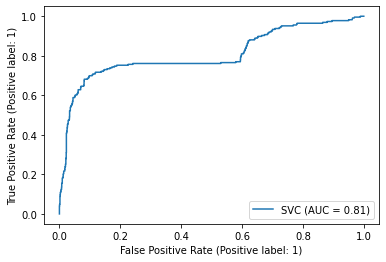

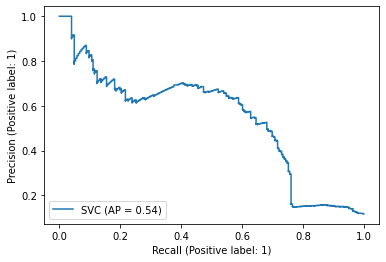

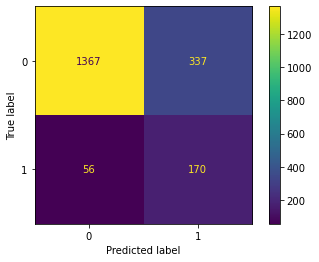

In [62]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_1, X_test, y_test)
plot_precision_recall_curve(rbf_svc_1, X_test, y_test)
plot_confusion_matrix(rbf_svc_1, X_test, y_test)

##CEN

In [51]:
# simple model train

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

CEN_data = pd.read_csv('Data/CEN.csv')

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_2 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_2.fit(X_train, y_train)

#save
dump(rbf_svc_2, "models/CENallen_model.joblib")
rbf_svc_2 = load('models/CENallen_model.joblib') 

cv_results = cross_validate(rbf_svc_2, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score fro non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.97 accuracy with a standard deviation of 0.01
0.74 f1 score for character class with a standard deviation of 0.05


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

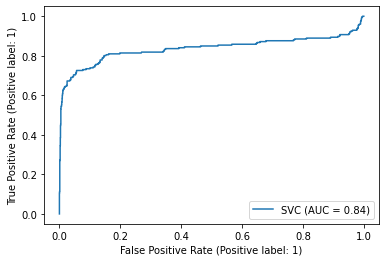

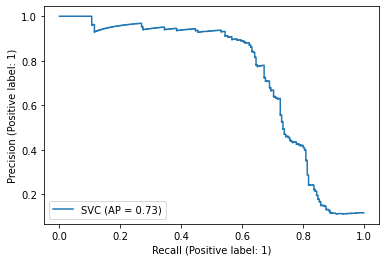

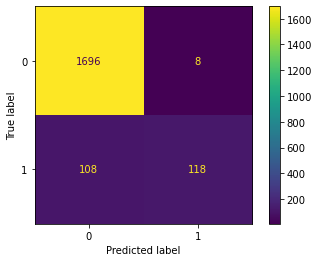

In [61]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_2, X_test, y_test)
plot_precision_recall_curve(rbf_svc_2, X_test, y_test)
plot_confusion_matrix(rbf_svc_2, X_test, y_test)

##Combo

In [53]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')
CEN_data = pd.read_csv('Data/CEN.csv')

Combo_data = pd.concat([PL_data, CEN_data])

data_y = Combo_data["character"].astype('int')
data_x = Combo_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_3 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_3.fit(X_train, y_train)

#save
dump(rbf_svc_3, "models/Comboallen_model.joblib")
rbf_svc_3 = load('models/Comboallen_model.joblib') 

cv_results = cross_validate(rbf_svc_3, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))

0.94 accuracy with a standard deviation of 0.01
0.67 f1 score for character class with a standard deviation of 0.05


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

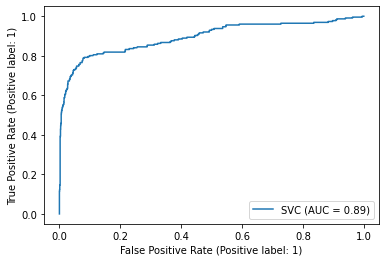

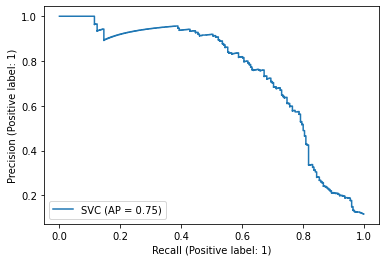

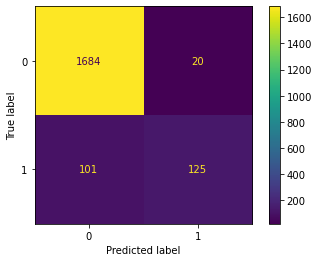

In [60]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_3, X_test, y_test)
plot_precision_recall_curve(rbf_svc_3, X_test, y_test)
plot_confusion_matrix(rbf_svc_3, X_test, y_test)

##Grid Search

###PL

In [64]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

PL_data = pd.read_csv('Data/PL.csv')

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.871 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.864 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.878 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.871 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.822 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.871 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.857 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.833 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.829 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.770 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [65]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       346
           1       0.80      0.69      0.74       132

    accuracy                           0.87       478
   macro avg       0.84      0.81      0.82       478
weighted avg       0.86      0.87      0.86       478



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

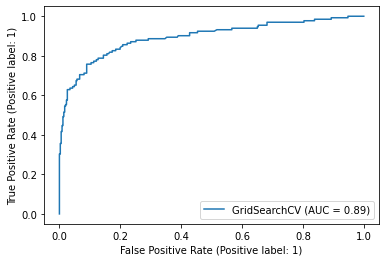

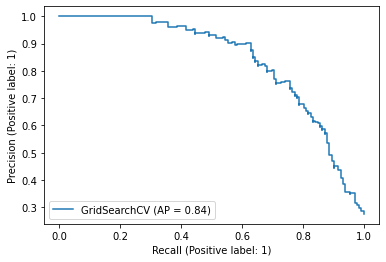

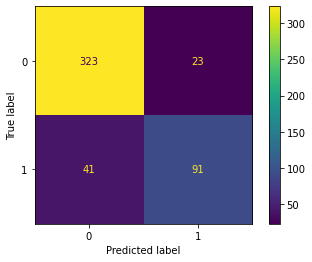

In [67]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)

###CEN

In [68]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

CEN_data = pd.read_csv('Data/CEN.csv')

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.954 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.947 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.949 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.948 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.958 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.954 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.956 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.954 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.955 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.943 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.938 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [28]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1372
           1       0.85      0.71      0.78        80

    accuracy                           0.98      1452
   macro avg       0.92      0.85      0.88      1452
weighted avg       0.98      0.98      0.98      1452



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

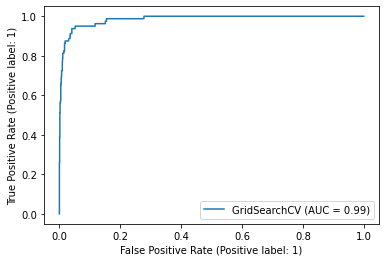

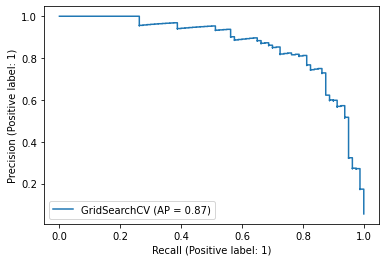

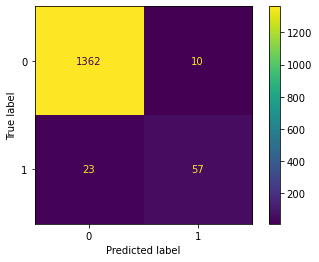

In [69]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)

###Combo


In [70]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

CEN_data = pd.read_csv('Data/CEN.csv')
PL_data = pd.read_csv('Data/PL.csv')
Combo_data = pd.concat([CEN_data, PL_data])

data_y = Combo_data["character"].astype('int')
data_x = Combo_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.926 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.934 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.938 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.927 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.925 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.919 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.921 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.927 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.915 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.914 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.897 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [31]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1736
           1       0.83      0.56      0.67       194

    accuracy                           0.94      1930
   macro avg       0.89      0.77      0.82      1930
weighted avg       0.94      0.94      0.94      1930



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

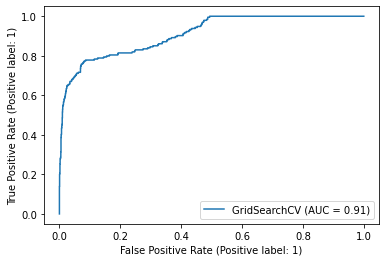

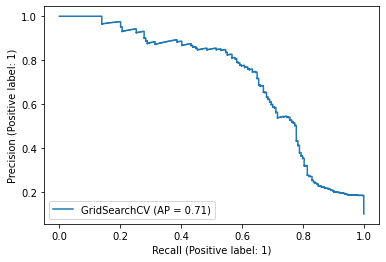

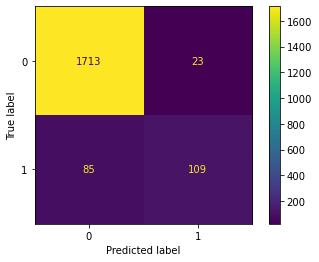

In [71]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)

#Additional Features

##Yake

###PL

In [72]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_4 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_4.fit(X_train, y_train)

#save
dump(rbf_svc_4, "models/PLallen_model_yake.joblib")
rbf_svc_4 = load('models/PLallen_model_yake.joblib') 

cv_results = cross_validate(rbf_svc_4, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.87 accuracy with a standard deviation of 0.03
0.76 f1 score for character class with a standard deviation of 0.07


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

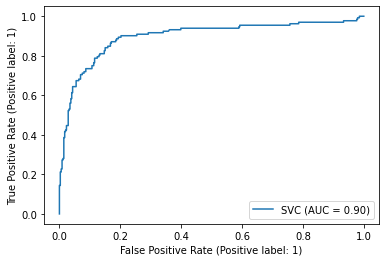

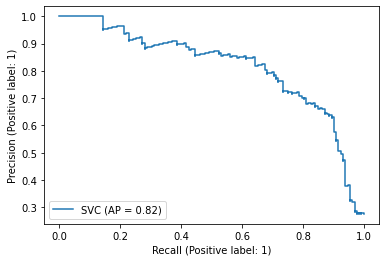

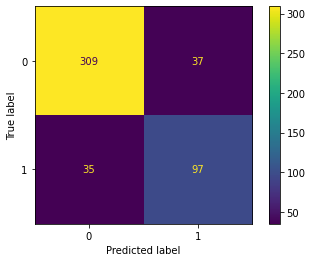

In [73]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_4, X_test, y_test)
plot_precision_recall_curve(rbf_svc_4, X_test, y_test)
plot_confusion_matrix(rbf_svc_4, X_test, y_test)

###CEN

In [74]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

CEN_data = pd.read_csv('Data/CEN.csv')

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_5 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_5.fit(X_train, y_train)

#save
dump(rbf_svc_5, "models/CENallen_model_yake.joblib")
rbf_svc_5 = load('models/CENallen_model_yake.joblib') 

cv_results = cross_validate(rbf_svc_5, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.97 accuracy with a standard deviation of 0.01
0.70 f1 score for character class with a standard deviation of 0.06


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

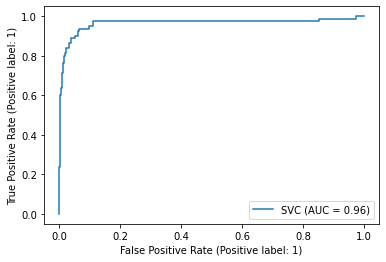

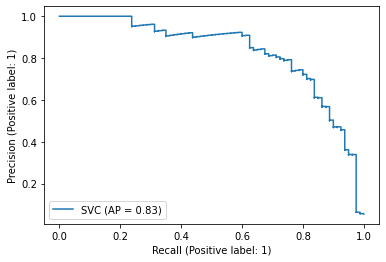

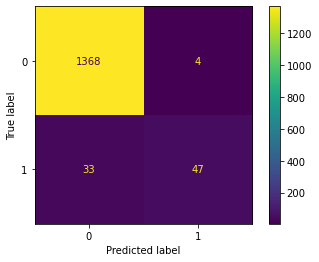

In [75]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_5, X_test, y_test)
plot_precision_recall_curve(rbf_svc_5, X_test, y_test)
plot_confusion_matrix(rbf_svc_5, X_test, y_test)

###Combo

In [76]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')
CEN_data = pd.read_csv('Data/CEN.csv')

Combo_data = pd.concat([PL_data, CEN_data])

data_y = Combo_data["character"].astype('int')
data_x = Combo_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_6 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_6.fit(X_train, y_train)

#save
dump(rbf_svc_6, "models/Comboallen_model_yake.joblib")
rbf_svc_6 = load('models/Comboallen_model_yake.joblib') 

cv_results = cross_validate(rbf_svc_6, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.94 accuracy with a standard deviation of 0.01
0.67 f1 score for character class with a standard deviation of 0.05


/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

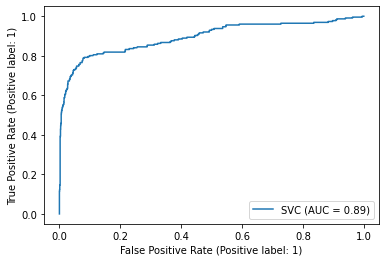

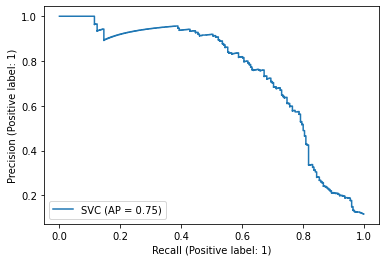

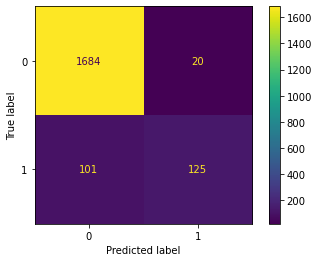

In [77]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(rbf_svc_6, X_test, y_test)
plot_precision_recall_curve(rbf_svc_6, X_test, y_test)
plot_confusion_matrix(rbf_svc_6, X_test, y_test)

##TF


###PL

In [34]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "TF"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_7 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_7.fit(X_train, y_train)

#save
dump(rbf_svc_7, "models/PLallen_model_tf.joblib")
rbf_svc_7 = load('models/PLallen_model_yake.joblib') 

cv_results = cross_validate(rbf_svc_7, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.86 accuracy with a standard deviation of 0.04
0.73 f1 score for character class with a standard deviation of 0.08


In [37]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

PL_data = pd.read_csv('Data/PL.csv')

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC", "TF"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_8 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_8.fit(X_train, y_train)

#save
dump(rbf_svc_8, "models/PLallen_model_yake_tf.joblib")
rbf_svc_8 = load('models/PLallen_model_yake_tf.joblib') 

cv_results = cross_validate(rbf_svc_8, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.87 accuracy with a standard deviation of 0.03
0.76 f1 score for character class with a standard deviation of 0.07


###CEN

In [41]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

CEN_data = pd.read_csv('Data/CEN.csv')

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "TF"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_9 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_9.fit(X_train, y_train)

#save
dump(rbf_svc_9, "models/CENallen_model_tf.joblib")
rbf_svc_9 = load('models/CENallen_model_yake.joblib') 

cv_results = cross_validate(rbf_svc_9, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.97 accuracy with a standard deviation of 0.01
0.74 f1 score for character class with a standard deviation of 0.05


In [42]:
# simple model 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from joblib import dump, load

CEN_data = pd.read_csv('Data/CEN.csv')

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC", "TF"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

rbf_svc_10 = svm.SVC(kernel = 'rbf', C=.5, gamma=1)

#fit
rbf_svc_10.fit(X_train, y_train)

#save
dump(rbf_svc_10, "models/CENallen_model_yake_tf.joblib")
rbf_svc_10 = load('models/CENallen_model_yake_tf.joblib') 

cv_results = cross_validate(rbf_svc_10, X_train, y_train, cv = 10, scoring=('f1', 'accuracy', 'f1_macro'), return_train_score=True)

# print(cv_results['train_accuracy'])
# print(cv_results['test_accuracy'])
# print(cv_results['train_f1'])
# print(cv_results['test_f1'])
# print(cv_results['test_f1_macro'])

print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("%0.2f f1 score for character class with a standard deviation of %0.2f" % (cv_results['test_f1'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score with a standard deviation of %0.2f" % (cv_results['test_f1_macro'].mean(), cv_results['test_f1'].std()))
# print("%0.2f f1 score for non character class" % (2*cv_results['test_f1_macro'].mean() - cv_results['test_f1'].mean()))

0.97 accuracy with a standard deviation of 0.01
0.70 f1 score for character class with a standard deviation of 0.06


##Grid Search for Yake

###Combo

In [78]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

CEN_data = pd.read_csv('Data/CEN.csv')
PL_data = pd.read_csv('Data/PL.csv')
Combo_data = pd.concat([CEN_data, PL_data])

data_y = Combo_data["character"].astype('int')
data_x = Combo_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.915 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.924 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.927 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.921 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.921 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.916 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.928 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.933 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.920 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.921 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.902 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [44]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1736
           1       0.82      0.58      0.68       194

    accuracy                           0.94      1930
   macro avg       0.89      0.78      0.82      1930
weighted avg       0.94      0.94      0.94      1930



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

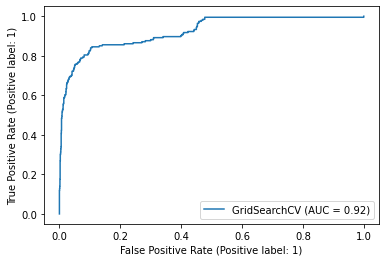

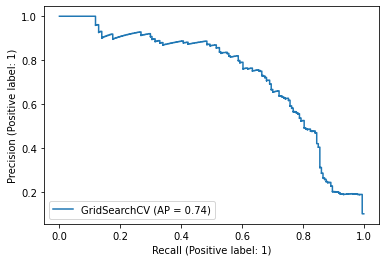

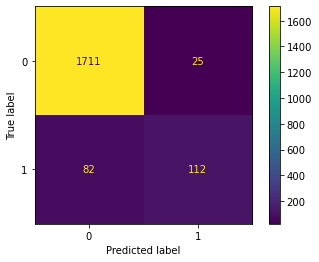

In [79]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)

###PL

In [80]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

# CEN_data = pd.read_csv('Data/CEN.csv')
PL_data = pd.read_csv('Data/PL.csv')
# Combo_data = pd.concat([CEN_data, PL_data])

data_y = PL_data["character"].astype('int')
data_x = PL_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.878 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.878 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.864 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.829 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.861 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.857 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.804 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [46]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       346
           1       0.77      0.74      0.76       132

    accuracy                           0.87       478
   macro avg       0.84      0.83      0.83       478
weighted avg       0.87      0.87      0.87       478



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

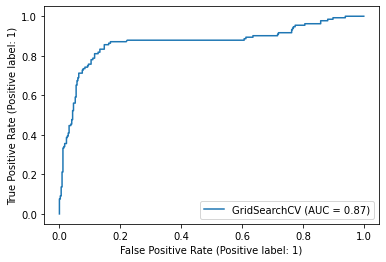

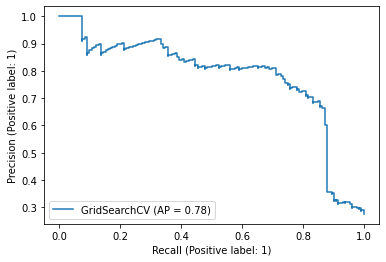

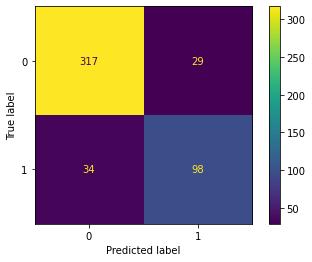

In [81]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)

###CEN

In [82]:
param_grid = {'C':[.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit= True, verbose=3)

CEN_data = pd.read_csv('Data/CEN.csv')
# PL_data = pd.read_csv('Data/PL.csv')
# Combo_data = pd.concat([CEN_data, PL_data])

data_y = CEN_data["character"].astype('int')
data_x = CEN_data[["CL", "CN", "DP", "NER", "SS", "TP", "WN", "animacy", "YK_SC"]]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, random_state=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.948 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.945 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.943 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.943 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.963 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.960 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.958 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.960 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.954 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.946 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [48]:
from sklearn.metrics import classification_report
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1372
           1       0.89      0.69      0.77        80

    accuracy                           0.98      1452
   macro avg       0.93      0.84      0.88      1452
weighted avg       0.98      0.98      0.98      1452



/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/eileen/miniconda3/envs/char_ext_2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; 

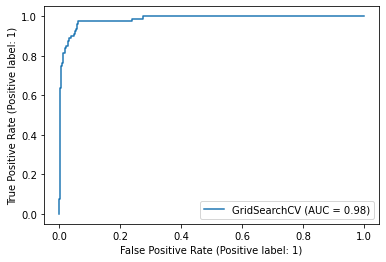

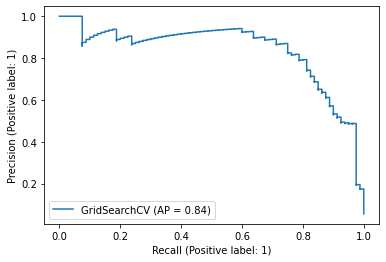

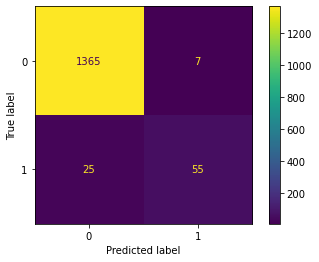

In [83]:
#graph ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

plot_roc_curve(grid, X_test, y_test)
plot_precision_recall_curve(grid, X_test, y_test)
plot_confusion_matrix(grid, X_test, y_test)